# K Nearest Neighbour Classification


In [1]:
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, mode, stdev
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [83]:
# Read in dataset from a .csv file called 'classifier_REDUCED'. 
# The number of sMCI datapoints had been reduced to match the pCMCI datapoints.
df = pd.read_csv('classifer_REDUCED.csv')
X = df[['RAVLT', 'LCHP', 'RCHP']]
y = df['GROUP']

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =.3, random_state = 0)

Feature scaling is due to the data being on different scales. It's important to correct for these differences after the train and test splitting to avoid leaking test data information into the rest of the pipeline. 

The scaling is fitted according to the training data and applied to both training and test sets. 

In [85]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now train the scaled classifier. 

In [86]:
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [87]:
y_pred = classifier.predict(X_test)

In [88]:
# Show the first 10 model predictions on the test data
classifier.predict(X_test)[0:10]

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [89]:
# Precision is the correct predictions considered correct: TP/(TP + FP)
# Recall is Sensitivity
# F1 score is the harmonic mean of precision and recall. 1 = all classes correctly predicted. 
# Sensitivity = TP / (TP + FN) = Recall (1, lower row)
# Specificity = TN / (TN + FP) = Recall (0, upper row)
# In confusion matrix (R, C), TN = 1,1 FP = 1,2 FN = 2,1 TP = 2,2

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.63      0.71      0.67        34
           1       0.68      0.60      0.64        35

    accuracy                           0.65        69
   macro avg       0.65      0.65      0.65        69
weighted avg       0.65      0.65      0.65        69

[[24 10]
 [14 21]]


Predicted,0,1,All
True,,,
0,24,10,34
1,14,21,35
All,38,31,69


In [90]:
# This outputs the accuracy (number of correct predictions / total number of predictions)
classifier.score(X_test, y_test)

0.6521739130434783

In [45]:
# Observe accuracies for different k

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,15)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

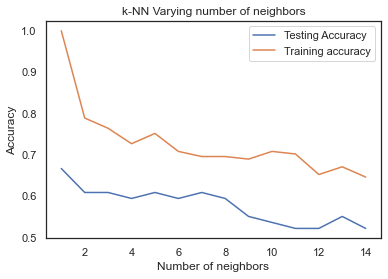

In [46]:
# Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [91]:
# ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [82]:
# Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.6382352941176471

In [18]:
# k-fold cross validation
from sklearn.model_selection import cross_val_score
knn_cv = KNeighborsClassifier(n_neighbors=7)

# Train model with a cv of 10
cv_scores = cross_val_score(knn_cv, X, y, cv=10)

# Print each CV score (accuracy) and average them
print(cv_scores)
print('Mean CV score: {}'.format(np.mean(cv_scores)))

[0.73913043 0.69565217 0.73913043 0.60869565 0.60869565 0.52173913
 0.56521739 0.65217391 0.43478261 0.73913043]
Mean CV score: 0.6304347826086956


The following cells are to make plots from the data. 

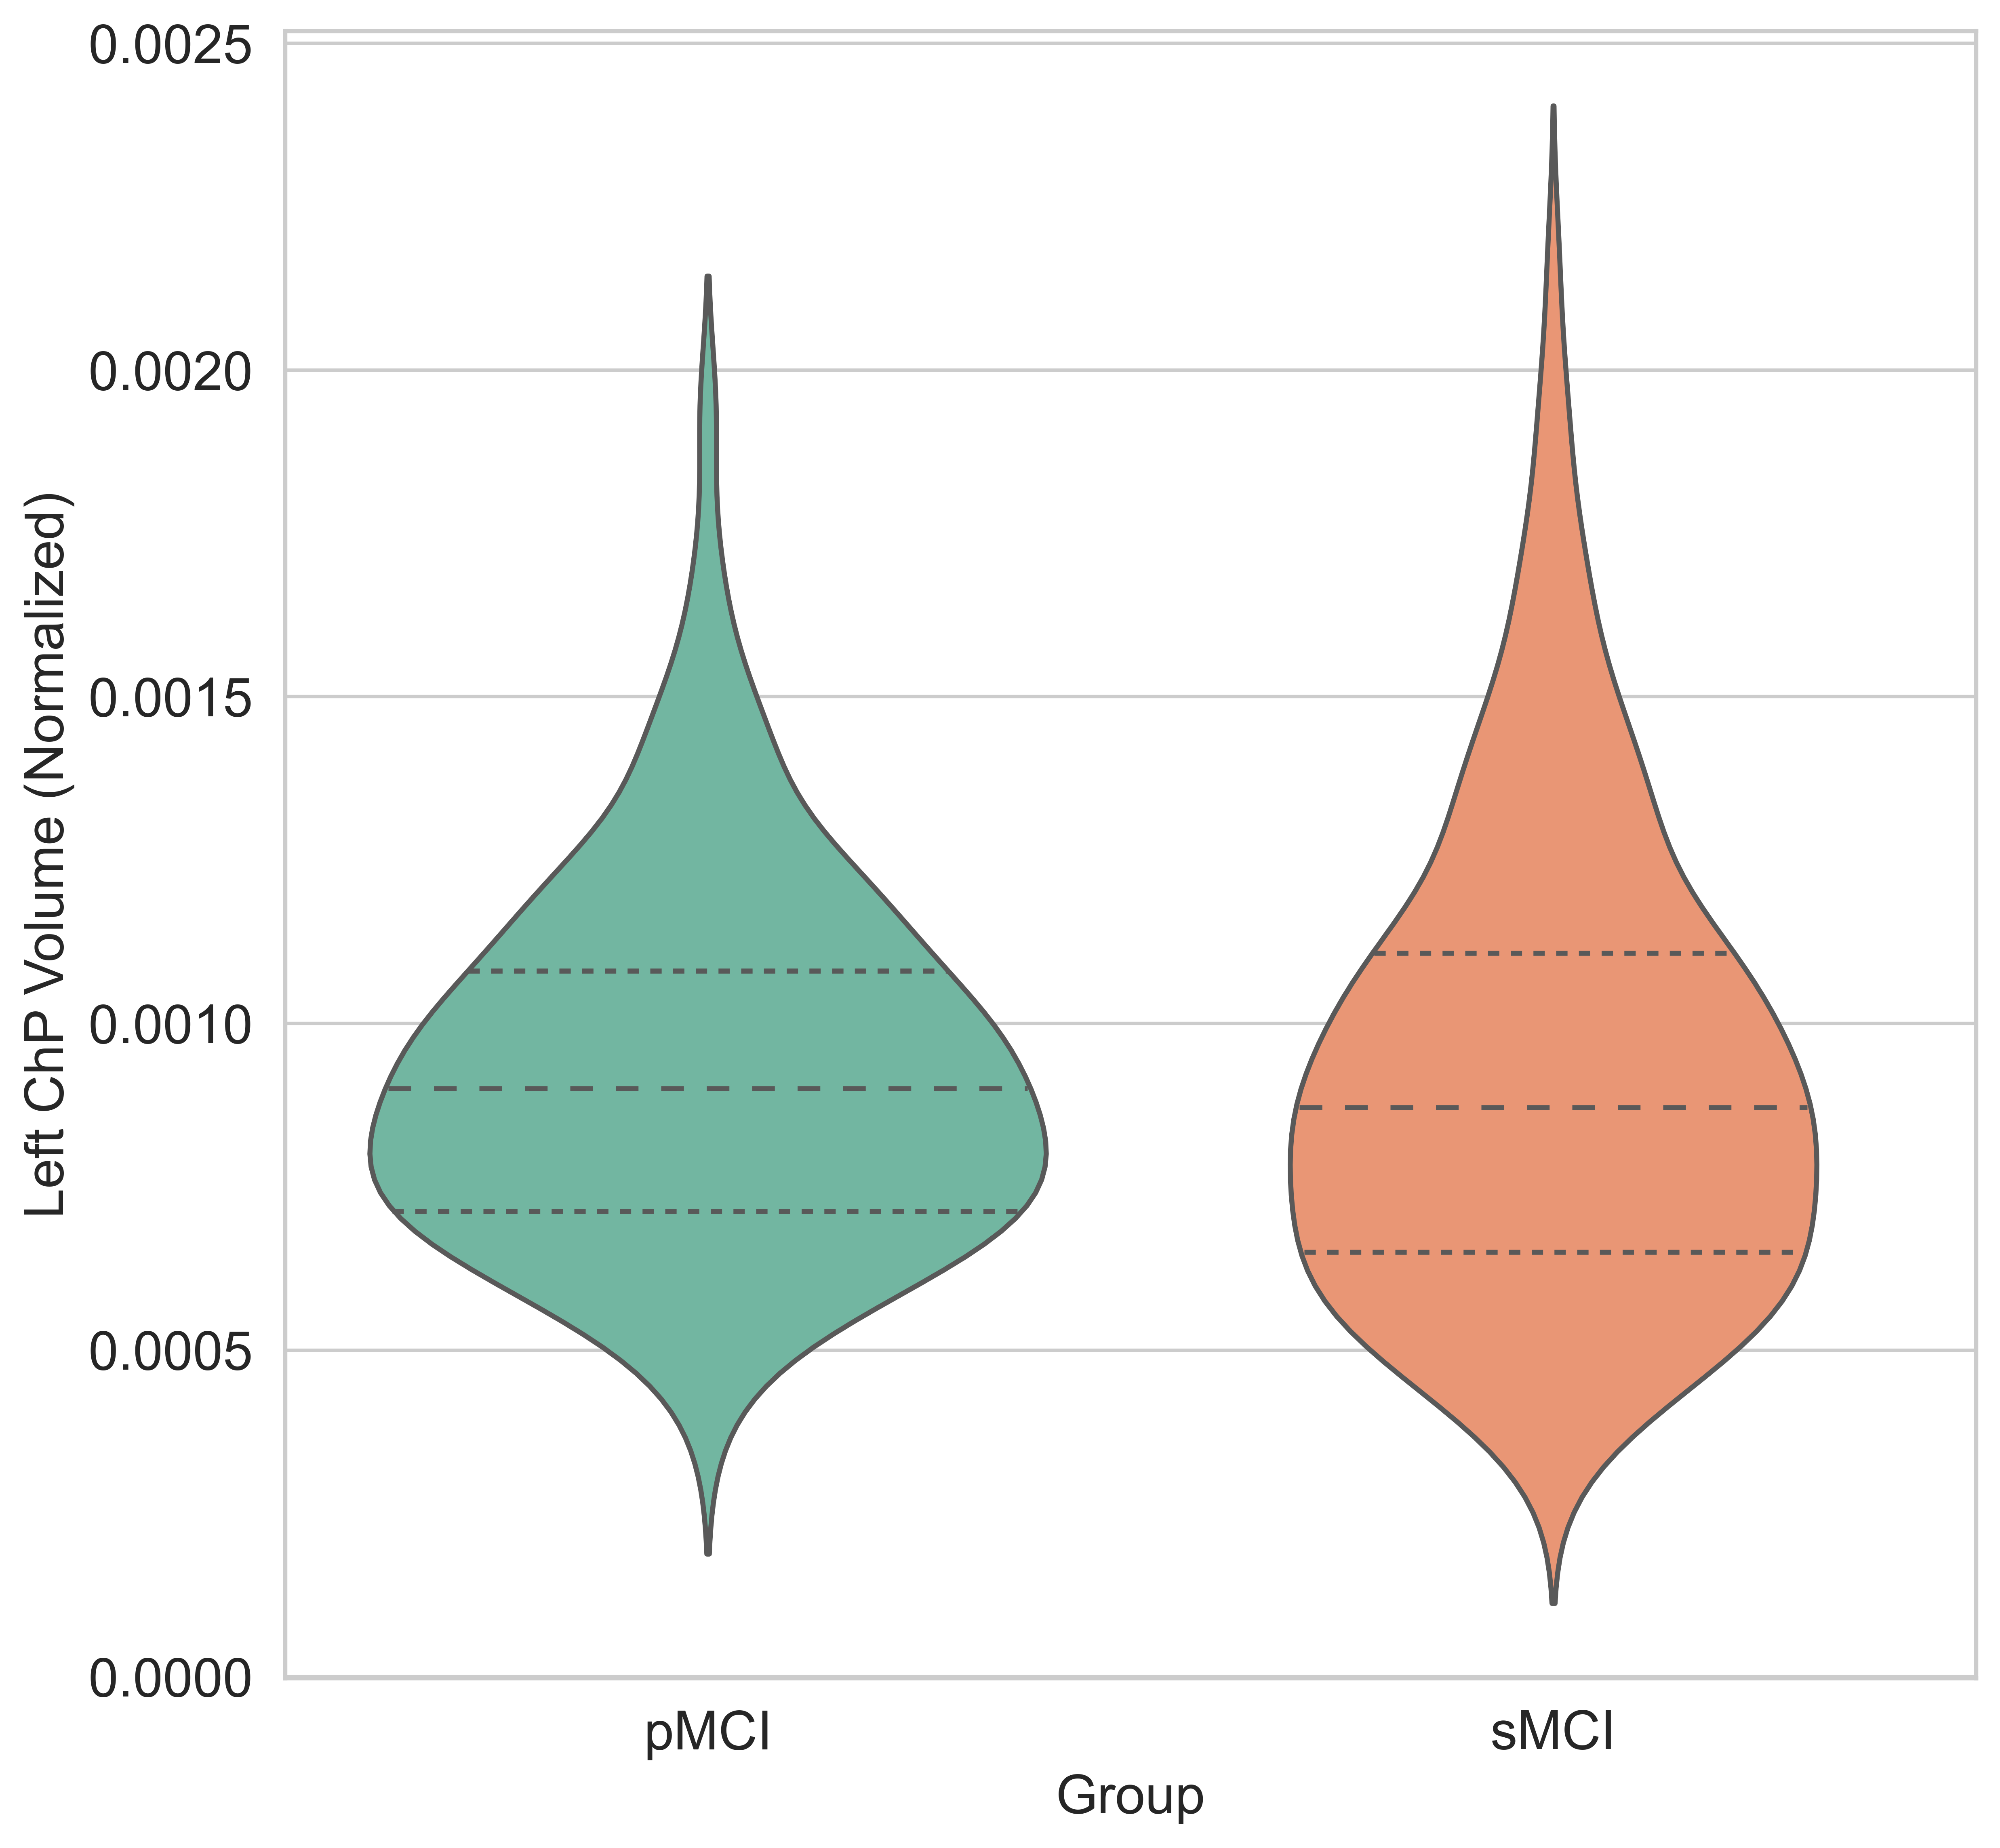

In [7]:
# Make violin plots from data
import seaborn as sn
sn.set(style = 'whitegrid')
plt.figure(figsize = (9,9), dpi = 600)
ax = sn.violinplot(x = df["GROUP"], y = df["LCHP"], inner = "quartile", palette = "Set2")
plt.tick_params(axis = 'x', labelsize = 16)
plt.tick_params(axis = 'y', labelsize = 16)
ax.set_ylabel("Left ChP Volume (Normalized)", fontsize = 16)
ax.set_xlabel("Group", fontsize = 16)
ax.set_xticklabels(['pMCI', 'sMCI'])

plt.savefig("LCHP_ViolinPlot.tiff")

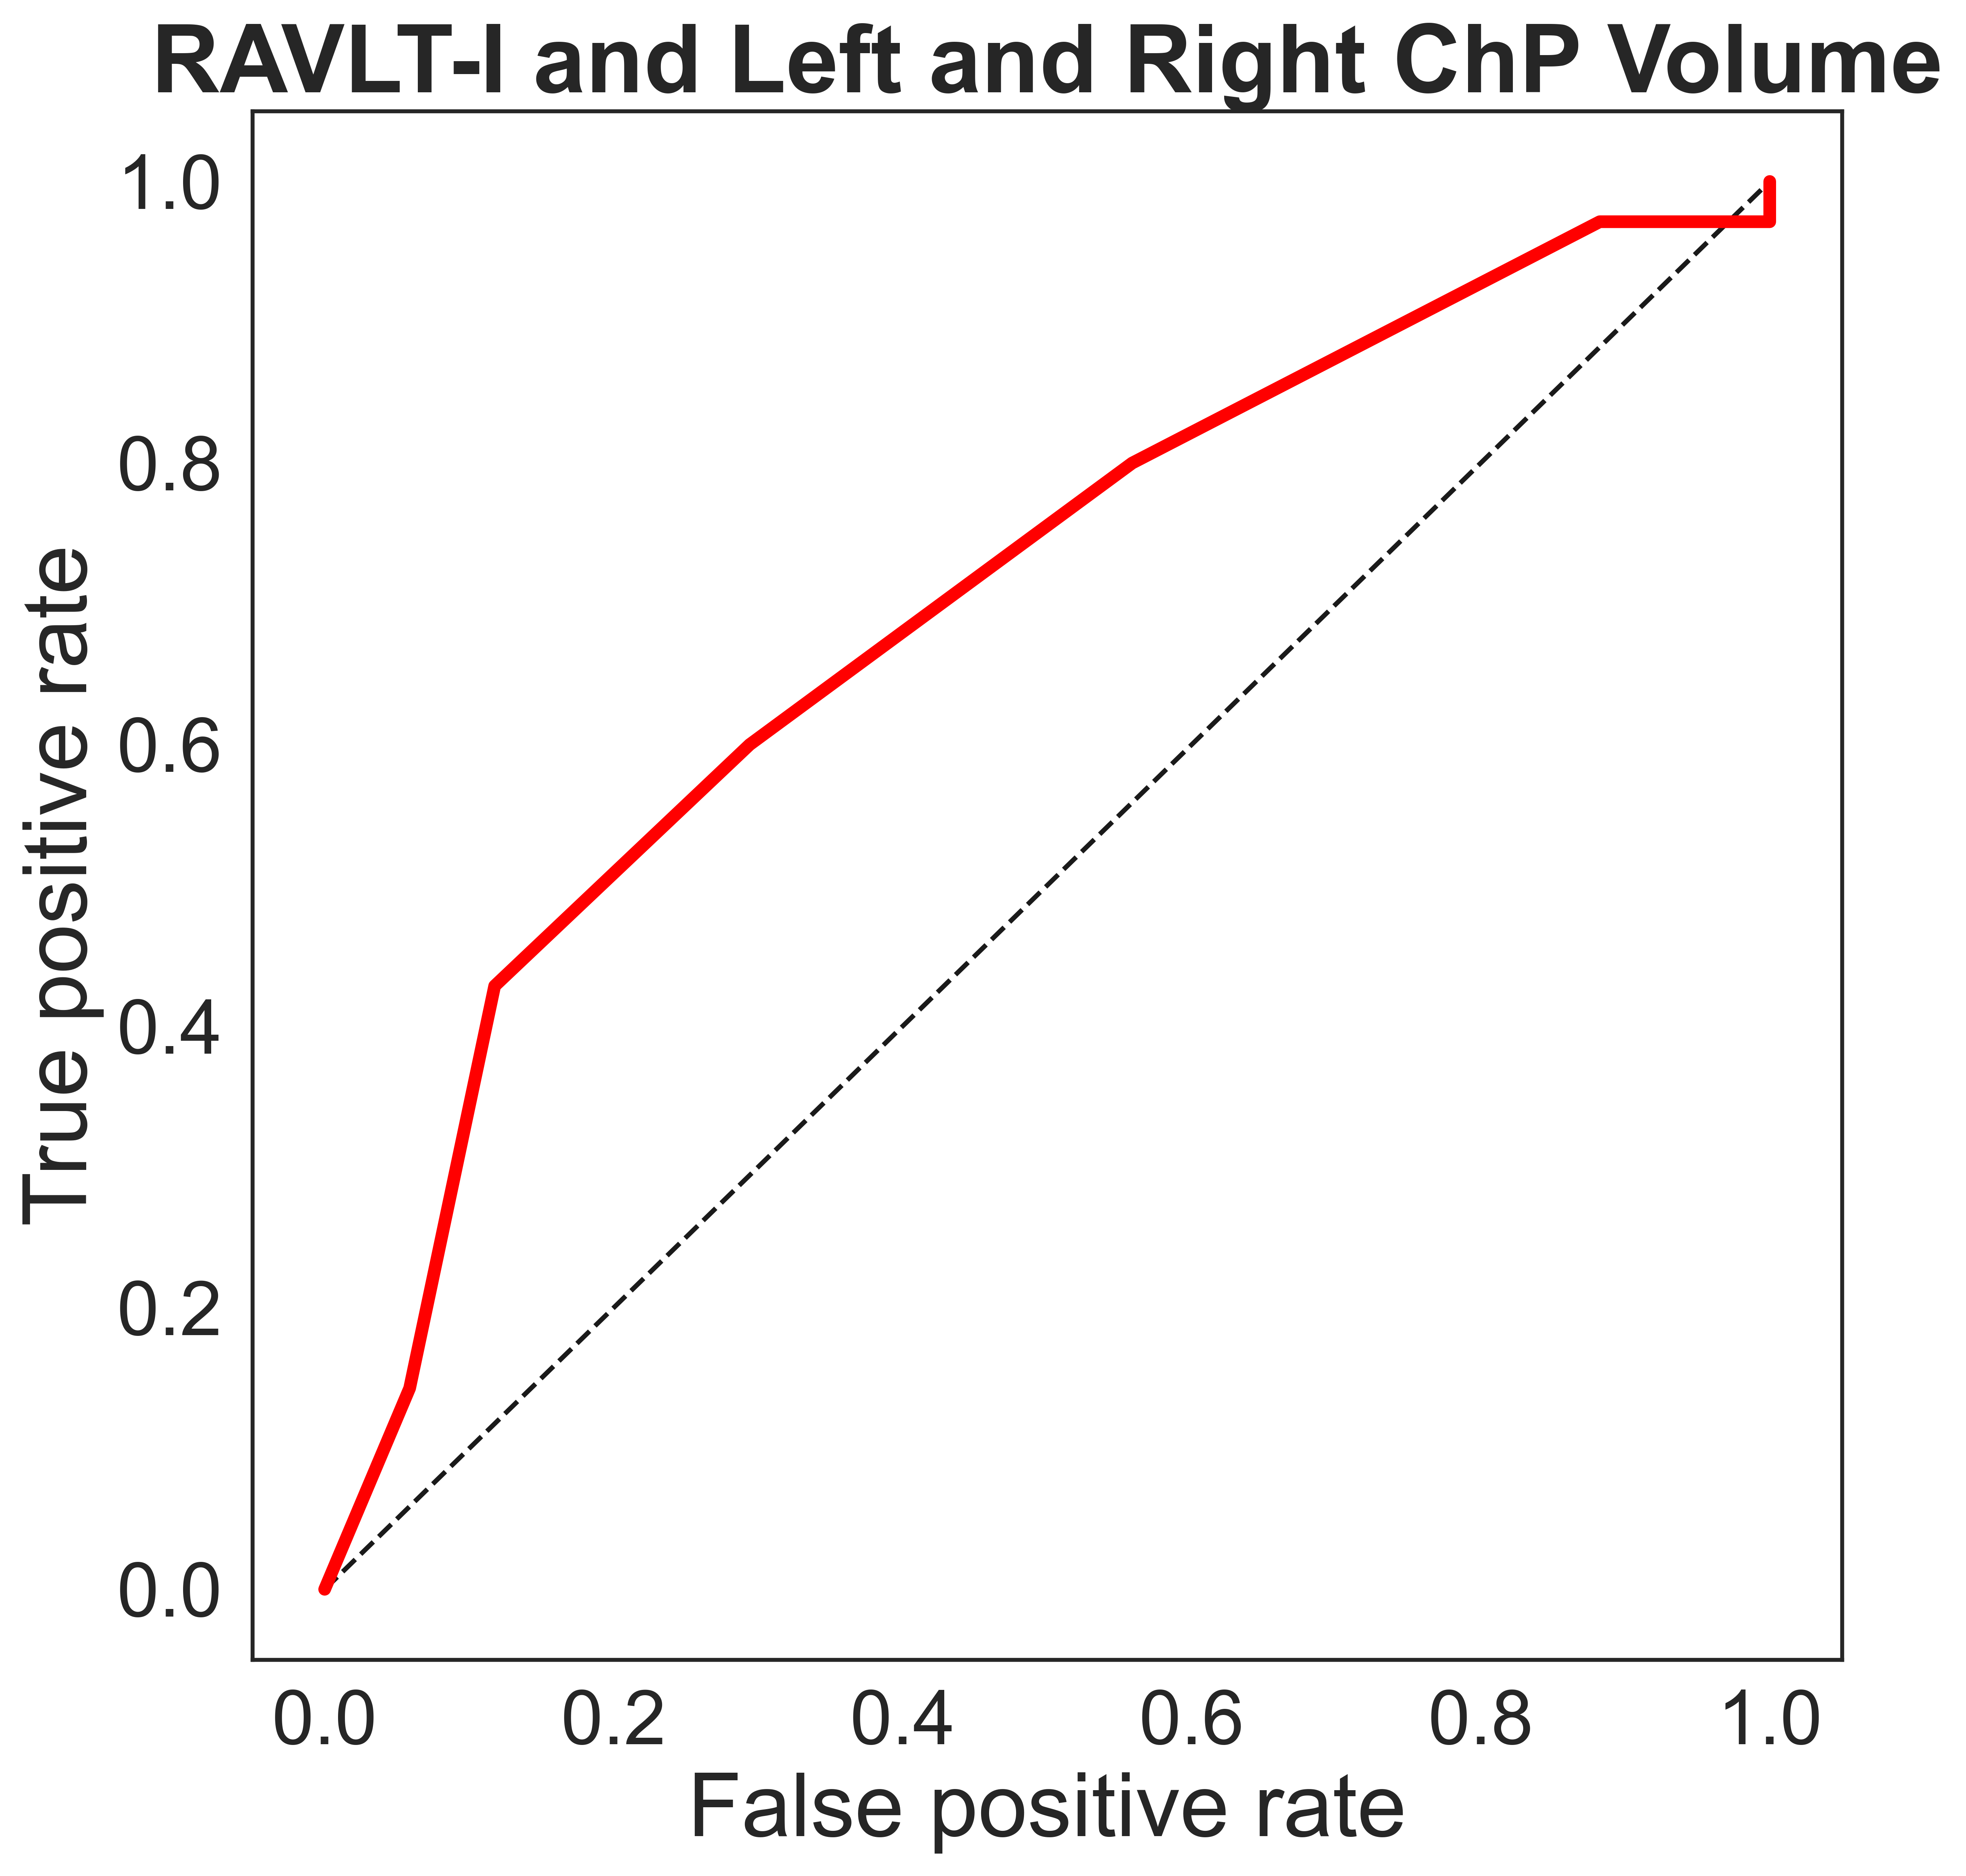

In [92]:
# Make ROC plot
import seaborn as sn
sn.set(style = 'white')
plt.figure(figsize = (9,9), dpi = 600, linewidth = 3)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn', color = 'red', linewidth = 4)
plt.xlabel('False positive rate', fontsize = 28)
plt.ylabel('True positive rate', fontsize = 28)
plt.title('RAVLT-I and Left and Right ChP Volume', fontsize = 30, weight = 'bold')
plt.tick_params(axis = 'x', labelsize = 24)
plt.tick_params(axis = 'y', labelsize = 24)
plt.savefig("RAVLT_LCHP_RCHP_ROC.tiff")